# Imports

In [41]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt
from statsmodels.stats import api as sms

from scipy.stats import shapiro, ttest_ind

# Data Load

In [9]:
df = pd.read_csv('../data/ab_data.csv')

In [10]:
df.shape

(294478, 5)

# 2.0 Design de Experimentos

## 2.1 Formulação das Hipóteses

## 2.2 Parametros do Experimento

In [11]:
proportion_efect = [0.14, 0.15, 0.16, 0.17, 0.18]

nivel_confianca = 0.95
nivel_significancia = 0.05

# conversoes da pagina atual e da nova
p1 = 0.13

list_n_sample = []
for p2 in proportion_efect:
    #p2 = 0.15

    effect_size = sms.proportion_effectsize(p1,p2)
    power = 0.8

    # Tamanho da Amostra
    sample_n = math.ceil(sms.NormalIndPower().solve_power(
        effect_size,
        power=power,
        alpha=nivel_significancia

    ))

    list_n_sample.append(sample_n)


In [12]:
list_n_sample

[18326, 4720, 2158, 1246, 818]

c:\Users\thale\Documents\Projetos_DS\ab_test\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thale\Documents\Projetos_DS\ab_test\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thale\Documents\Projetos_DS\ab_test\env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\thale\Documents\Projetos_DS\ab_test\env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

<Axes: xlabel='Percentual da nova Página', ylabel='Tamanho da Amostra'>

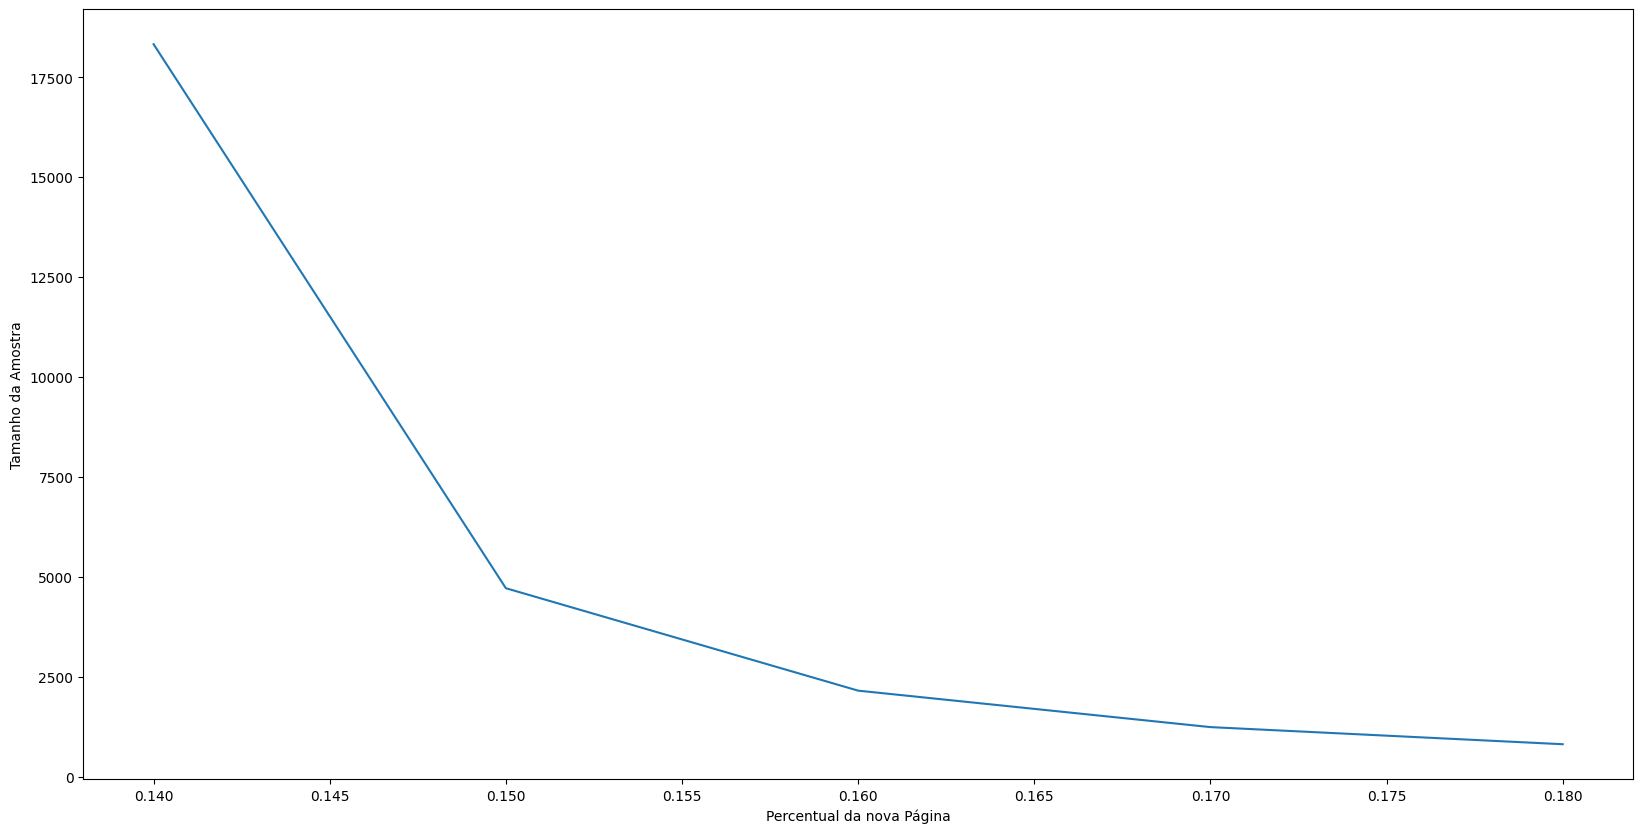

In [13]:
plt.figure(figsize=(20,10))
plt.xlabel('Percentual da nova Página')
plt.ylabel('Tamanho da Amostra')
sns.lineplot(x=proportion_efect, y=list_n_sample)

# 3.0 Análise Descritiva dos Dados

In [14]:
df3 = df.copy()

## 3.1 Dimensão dos Dados

In [15]:
print('Número de Linhas: {}'.format(df3.shape[0]))
print('Número de Colunas: {}'.format(df3.shape[0]))

Número de Linhas: 294478
Número de Colunas: 294478


## 3.2 Check Na

In [16]:
df3.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [17]:
df3 = df3.dropna()

## 3.3 Conferir Flags

In [18]:
df3[['user_id','group','landing_page']].groupby(['group', 'landing_page']).count().reset_index()

,group,landing_page,user_id
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145311
3,treatment,old_page,1965


In [19]:
df_user_delete = df3[['user_id', 'group']].groupby('user_id').count().reset_index().query('group > 1')['user_id']

df4 = df3[~df3['user_id'].isin(df_user_delete)]

In [20]:
df4.shape

(286690, 5)

# 4.0 Amostragem Aleatória dos Grupos Controle e Tratamento

In [21]:
df_control_sample = df4[df4['group'] == 'control'].sample(n=4720, random_state=42)

df_treatment_sample = df4[df4['group'] == 'treatment'].sample(n=4720, random_state=42)


df_ab = pd.concat([df_control_sample, df_treatment_sample]).reset_index(drop=True)
df_ab

,user_id,timestamp,group,landing_page,converted
0,663037,2017-01-05 02:13:38.063443,control,old_page,0
1,932826,2017-01-13 04:50:06.941679,control,old_page,1
2,922999,2017-01-04 07:19:23.813317,control,old_page,0
3,857826,2017-01-19 02:27:37.678241,control,old_page,0
4,762926,2017-01-18 17:50:59.261406,control,old_page,0
...,...,...,...,...,...
9435,649363,2017-01-13 00:10:17.571044,treatment,new_page,0
9436,868879,2017-01-06 12:21:41.396652,treatment,new_page,0
9437,792022,2017-01-24 03:55:24.551307,treatment,new_page,0
9438,663570,2017-01-04 03:04:33.647683,treatment,new_page,0


## 4.1 Calcular a Conversão entre os grupos

In [22]:
# Conversão = Número de Compradores/Número total de visitantes


conversao_control = df_ab[(df_ab['group'] == 'control') & (df_ab['converted'] == 1)].shape[0] / df_ab[(df_ab['group'] == 'control')].shape[0]
print('Taxa de Conversão do Grupo Controle: ', np.round(conversao_control*100,2))


conversao_treatment = df_ab[(df_ab['group'] == 'treatment') & (df_ab['converted'] == 1)].shape[0] / df_ab[(df_ab['group'] == 'treatment')].shape[0]
print('Taxa de Conversão do Grupo Tratamento: ', np.round(conversao_treatment*100,2))

Taxa de Conversão do Grupo Controle:  11.55
Taxa de Conversão do Grupo Tratamento:  12.9


# 5.0 Testes Estatísticos

## 5.1 Situação Problema 1

- Vamos simular um caso para entender um pouco mais sobre testes estatísticos

- Imagina que uma bióloga gostaria de saber se altura média de uma certa espécie de
planta é igual a 15 cm. Ela coleta amostras aleatórias de 12 plantas and anota cada uma
de suas alturas em cm.

In [23]:
df = [14, 14, 16, 13, 12, 17, 15, 14, 15, 13, 15, 14]

- Tipo dos dados: Contínuos

- Tipo de Pergunta: Diferenças

- Diferença entre o que: Médias

- Quantas amostras: 1

- Teste de Inferência Estatística que devemos usar: One-Sample T-test

In [24]:
from scipy.stats import ttest_1samp
statistic, pvalue = ttest_1samp(df, popmean=15)

print('Valor de pvalue = {}'.format(pvalue))

Valor de pvalue = 0.12014460742498101


In [25]:
# Hipóteses

#H0: Não há diferença da amostra atual em relação ao benchmark de 15 cm
#H1: Há diferença entre a amostra em relação ao benchmark de 15cm

alpha = 0.05
if pvalue < alpha:
    print('Rejeitamos a hipótese Nula')
else:
    print('Falha em rejeitar a hipótese Nula')

# Se pvalue for < alpha rejeitamos a hipótese nula.
    # Ou seja, a altura média das plantas é diferente de 15cm

# Se pvalue > alpha, não existe evidência suficiente para se rejeitar H0.
    # Ou seja, as plantas podem ter em média 15 cm

Falha em rejeitar a hipótese Nula


## Situação Problema 2

- Pesquisadores gostariam de saber se duas espécies diferentes de plantas tem a mesma
altura média. Eles coletaram amostras aleatórias de 20 plantas de cada espécie.

In [26]:
df1 = np.array([14, 15, 15, 16, 13, 8, 14, 17, 16, 14, 19, 20, 21, 15, 15, 16, 16, 13, 14, 12])
df2 = np.array([15, 17, 14, 17, 14, 8, 12, 19, 19, 14, 17, 22, 24, 16, 13, 16, 13, 18, 15, 13])

In [29]:
print('Média da Amostra 1: {}'.format(np.mean(df1)))
print('Média da Amostra 2: {}'.format(np.mean(df2)))

Média da Amostra 1: 15.15
Média da Amostra 2: 15.8


- Agora preciamos verificar se a diferença das duas amostras é significativa a ponto de dizer que elas possuem uma altura totalmente diferente ou não.

In [ ]:
# H0: A média de altura das duas amostras de plantas são iguais
# H1: A média de altura das duas amostras são diferentes

- Tipo do Dado: Contínuo
- Relacional ou Diferença: Diferença
- Diferença do que?: Média
- Quantidade de Grupos: 2 Grupos
- Satisfaz as Assumptions Parametrics?: Vamos Avaliar...

## Assumptions Parametrics:

1. Independências entre as amostras
2. Dados Normalmente Distribuídos
3. Variância Igual

In [39]:
## 1) Independencias entre as amostras (ok)

## 2) Dados Normalmente Distribuídos (OK)

# O teste de shapiro também é um teste AB. Consequentemente também tem hipóteses h0 e h1.

# H0: Os dados são normalmente distribuídos
# H1: Os dados não são normalmente distribuídos

stats1, pvalue1 = shapiro(df1)
stats2, pvalue2 = shapiro(df2)

alpha = 0.05

if alpha < pvalue1:
    print('Os dados de df1 são normalmente distribuídos')
else:
    print('Os dados de df1 não são normalmente distribuídos')

if alpha < pvalue2:
    print('Os dados de df2 são normalmente distribuídos')
else:
    print('Os dados de df2 não são normalmente distribuídos')

# 3) Variâncias Iguais

print('Var df1: {}'.format(np.var(df1)))
print('Var df2: {}'.format(np.var(df2)))

if np.var(df2)/np.var(df1) < 4:
    print('Variâncias iguais')
else:
    print('Variâncias Diferentes')

Os dados de df1 são normalmente distribuídos
Os dados de df2 são normalmente distribuídos
Var df1: 7.727500000000001
Var df2: 12.260000000000002
Variâncias iguais


- As Assumptions foram satisfeitas. Portanto, devemos seguir com o teste TWO SAMPLE T-TEST

In [43]:
stats, pvalue = ttest_ind(df1, df2)

alpha = 0.05

if alpha < pvalue:
    print('As médias das alturas das plantas são iguais')
else:
    print('As médias das alturas das plantas não são iguais')

As médias das alturas das plantas são iguais
